<div align="center">

# 📌 Project 2

## 📚 Modelos de Crédito 

### Sofía Hernández Zatarain
### Alejandra Elizabeth Figueroa Arellano
### Patrick Fernandez Barcena Vazquez
### Axel Santiago Molina Ceja


#### 🎓 Professor: Rodolfo Slay

</div>

### Libraries

📦 Se importan las librerías necesarias

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

### Data Visualization

In [45]:
data = pd.read_csv('train.csv')
data.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good


### Search for nulls

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000 non-null  ob

### Drop irrelevant columns

In [47]:
data.drop(columns=['ID', 'Customer_ID', 'SSN', 'Name','Type_of_Loan'], inplace=True)

### Feature Selection and Data Preparation

In [48]:
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Encode categorical variables

In [49]:
categorical_cols = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])  
    X_test[col] = le.transform(X_test[col]) 
    label_encoders[col] = le

### Winsorization for outliers

In [50]:
for col in X_train.select_dtypes(include=['float64', 'int64']).columns:
    lower, upper = np.percentile(X_train[col], [1, 99])
    X_train[col] = np.clip(X_train[col], lower, upper)
    X_test[col] = np.clip(X_test[col], lower, upper)

### Data Standarization
Se aplica `StandardScaler` para normalizar las variables numéricas, lo cual mejora el rendimiento de algunos modelos.

In [51]:
scaler = StandardScaler()
X_train[X_train.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(X_train[X_train.select_dtypes(include=['float64', 'int64']).columns])
X_test[X_test.select_dtypes(include=['float64', 'int64']).columns] = scaler.transform(X_test[X_test.select_dtypes(include=['float64', 'int64']).columns])

### Credit Score Distribution

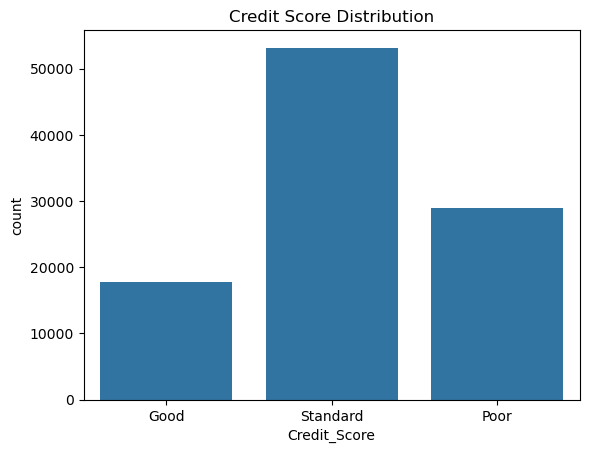

In [52]:
sns.countplot(x=data["Credit_Score"])
plt.title("Credit Score Distribution")
plt.show()

The distribution is moderately inbalanced

### Y Encoding

In [53]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Data balancing

In [54]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

### Model Training
Se entrenan varios modelos: Regresión Logística, Random Forest, Gradient Boosting y XGBoost.

In [55]:
log_reg = LogisticRegression(class_weight=class_weight_dict)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=class_weights[1] / class_weights[0])

In [56]:
log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
gb_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:57:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

### Testing

In [57]:
y_pred_log = log_reg.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_gb = gb_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

In [58]:
acc_log = accuracy_score(y_test, y_pred_log)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_gb = accuracy_score(y_test, y_pred_gb)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy LogReg: {acc_log:.4f}, RandomForest: {acc_rf:.4f}, GradientBoosting: {acc_gb:.4f}, XGBoost: {acc_xgb:.4f}')

Accuracy LogReg: 0.6529, RandomForest: 0.8317, GradientBoosting: 0.7175, XGBoost: 0.7869


### Confusion Matrix and Classification Report for Random Forest
Se evalúa el rendimiento de los modelos utilizando `accuracy`, `precision`, `recall`, y `f1-score`.

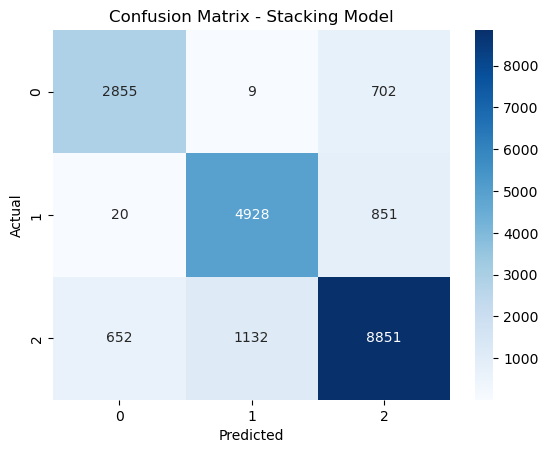

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      3566
           1       0.81      0.85      0.83      5799
           2       0.85      0.83      0.84     10635

    accuracy                           0.83     20000
   macro avg       0.82      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



,Score
Accuracy,0.831700
Precision (macro),0.824065
Recall (macro),0.827557
F1 Score (macro),0.825626


In [97]:
conf_matrix_stacking = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_stacking, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Stacking Model')
plt.show()


# Reporte de clasificación (por clase)
print("Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

# Métricas agregadas en DataFrame
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision (macro)': precision_score(y_test, y_pred_rf, average='macro'),
    'Recall (macro)': recall_score(y_test, y_pred_rf, average='macro'),
    'F1 Score (macro)': f1_score(y_test, y_pred_rf, average='macro')
}
metrics_df = pd.DataFrame(metrics, index=["Score"]).T
display(metrics_df)


### Stacking model to combine all four previous models

In [59]:
meta_model = LogisticRegression()

In [60]:
stacking_model = StackingClassifier(
    estimators=[('log_reg', log_reg), ('rf', rf_clf), ('gb', gb_clf), ('xgb', xgb_clf)],
    final_estimator=meta_model
)

In [61]:
stacking_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:03:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:03:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:03:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fo

StackingClassifier(estimators=[('log_reg',
                                LogisticRegression(class_weight={0: 1.8697704856728836,
                                                                 1: 1.14947483368536,
                                                                 2: 0.6268757297225291})),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              c...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression())

### Stacking Model Testing

In [62]:
y_pred_stacking = stacking_model.predict(X_test)

In [63]:
acc_stacking = accuracy_score(y_test, y_pred_stacking)
print(f'Accuracy Stacking Model: {acc_stacking:.4f}')

Accuracy Stacking Model: 0.8323


### Confusion Matrix and classification report for stacking

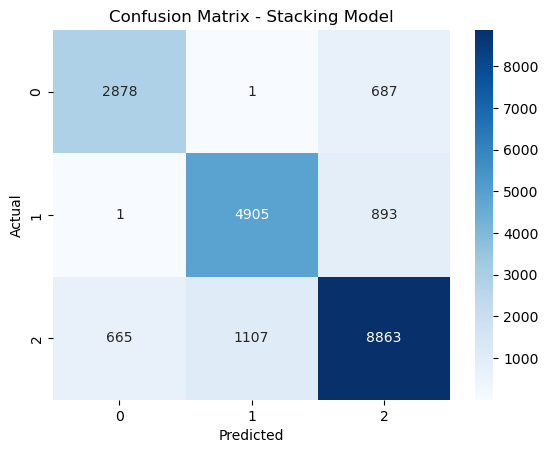

In [64]:
conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
sns.heatmap(conf_matrix_stacking, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Stacking Model')
plt.show()

In [76]:
# Reporte de clasificación (por clase)
print("Classification Report:\n")
print(classification_report(y_test, y_pred_stacking))

# Métricas agregadas en DataFrame
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_stacking),
    'Precision (macro)': precision_score(y_test, y_pred_stacking, average='macro'),
    'Recall (macro)': recall_score(y_test, y_pred_stacking, average='macro'),
    'F1 Score (macro)': f1_score(y_test, y_pred_stacking, average='macro')
}
metrics_df = pd.DataFrame(metrics, index=["Score"]).T
display(metrics_df)


Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      3566
           1       0.82      0.85      0.83      5799
           2       0.85      0.83      0.84     10635

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



,Score
Accuracy,0.832300
Precision (macro),0.825504
Recall (macro),0.828761
F1 Score (macro),0.827016


### Cross Validation

In [65]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_stacking = cross_val_score(stacking_model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
print(f'Stacking Cross-validation Accuracy: {cv_scores_stacking.mean():.4f} ± {cv_scores_stacking.std():.4f}')

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:08:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:08:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:08:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fo

Stacking Cross-validation Accuracy: 0.8223 ± 0.0033


## Model Optimization

#### Using GridSearchCV (with Confusion Matrix and classification report)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fo

Mejores hiperparámetros encontrados:
{'final_estimator__C': 1, 'gb__n_estimators': 100, 'rf__max_depth': 5, 'rf__n_estimators': 200, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6}


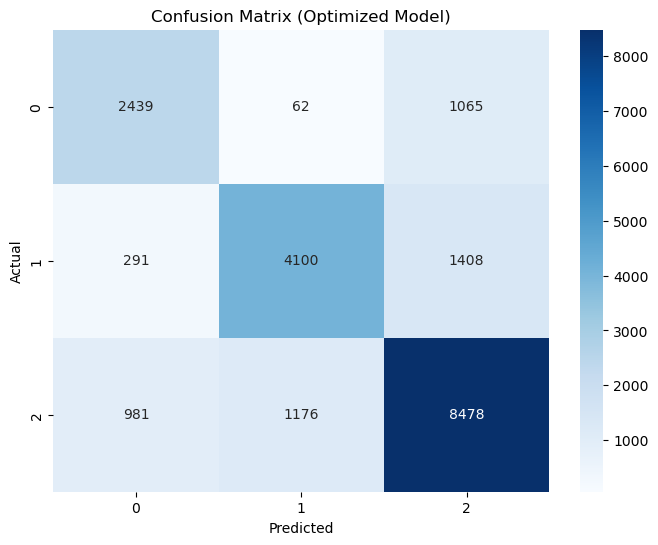

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3566
           1       0.77      0.71      0.74      5799
           2       0.77      0.80      0.79     10635

    accuracy                           0.75     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.75      0.75      0.75     20000



,Score
Accuracy,0.750850
Precision (macro),0.733163
Recall (macro),0.729386
F1 Score (macro),0.730708


In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Definimos de nuevo el modelo base
meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=[('log_reg', log_reg), ('rf', rf_clf), ('gb', gb_clf), ('xgb', xgb_clf)],
    final_estimator=meta_model,
    cv=5
)

# Hiperparámetros a optimizar (algunos ejemplos clave)
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [5, 10],
    'gb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [3, 6],
    'final_estimator__C': [0.01, 0.1, 1]
}

# Búsqueda en grid enfocada en precisión macro
grid = GridSearchCV(estimator=stacking_model, param_grid=param_grid,
                    scoring='precision_macro', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Resultados
best_model = grid.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)

# Evaluación del modelo optimizado
y_pred_optimized = best_model.predict(X_test)

# Matriz de confusión bonita
cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix (Optimized Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_optimized))

# Métricas globales
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_optimized),
    'Precision (macro)': precision_score(y_test, y_pred_optimized, average='macro'),
    'Recall (macro)': recall_score(y_test, y_pred_optimized, average='macro'),
    'F1 Score (macro)': f1_score(y_test, y_pred_optimized, average='macro')
}
metrics_df = pd.DataFrame(metrics, index=["Score"]).T
display(metrics_df)


#### Using Optuna

In [81]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, make_scorer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

def objective(trial):
    # Hiperparámetros sugeridos por Optuna
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
    rf_max_depth = trial.suggest_int('rf_max_depth', 3, 10)

    gb_n_estimators = trial.suggest_int('gb_n_estimators', 50, 200)
    gb_learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.2)

    xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 10)
    xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.2)

    meta_C = trial.suggest_float('meta_C', 0.01, 1.0)

    # Set params en los clasificadores
    rf_clf.set_params(n_estimators=rf_n_estimators, max_depth=rf_max_depth)
    gb_clf.set_params(n_estimators=gb_n_estimators, learning_rate=gb_learning_rate)
    xgb_clf.set_params(max_depth=xgb_max_depth, learning_rate=xgb_learning_rate)
    meta_model = LogisticRegression(C=meta_C, max_iter=1000)

    model = StackingClassifier(
        estimators=[('log_reg', log_reg), ('rf', rf_clf), ('gb', gb_clf), ('xgb', xgb_clf)],
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )

    scores = cross_val_score(model, X_train, y_train, cv=3,
                             scoring='precision_macro', n_jobs=-1)
    
    return scores.mean()

# Ejecutar
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)

"""
Mejores hiperparámetros encontrados:
{'rf_n_estimators': 85, 'rf_max_depth': 4, 'gb_n_estimators': 161, 'gb_learning_rate': 0.16124705540846734, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.13750352043832725, 'meta_C': 0.7880361880099094}
"""

[I 2025-05-06 20:36:37,090] A new study created in memory with name: no-name-af04f826-6bed-4cba-a1dd-514a8aad2e67
[20:36:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[20:36:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[20:36:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[20:37:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[20:37:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[20:37:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[20:37:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[20:

Mejores hiperparámetros encontrados:
{'rf_n_estimators': 85, 'rf_max_depth': 4, 'gb_n_estimators': 161, 'gb_learning_rate': 0.16124705540846734, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.13750352043832725, 'meta_C': 0.7880361880099094}


#### Confusion Matrix and classification report for Optuna

In [82]:
best_params = study.best_params

# Aplicar los mejores valores
rf_clf.set_params(n_estimators=best_params['rf_n_estimators'], max_depth=best_params['rf_max_depth'])
gb_clf.set_params(n_estimators=best_params['gb_n_estimators'], learning_rate=best_params['gb_learning_rate'])
xgb_clf.set_params(max_depth=best_params['xgb_max_depth'], learning_rate=best_params['xgb_learning_rate'])
meta_model = LogisticRegression(C=best_params['meta_C'], max_iter=1000)

# Modelo final
best_model = StackingClassifier(
    estimators=[('log_reg', log_reg), ('rf', rf_clf), ('gb', gb_clf), ('xgb', xgb_clf)],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

best_model.fit(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:06:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[00:08:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[00:08:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[00:08:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[00:08:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

[00:08:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.



StackingClassifier(cv=5,
                   estimators=[('log_reg',
                                LogisticRegression(class_weight={0: 1.8697704856728836,
                                                                 1: 1.14947483368536,
                                                                 2: 0.6268757297225291})),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=4,
                                                       n_estimators=85,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.16124705540846734,
                                                           n_estimators=161,
                                                           random_state=42)),
                               ('xgb...
                                              learning_rate=0.13750352043832725,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(C=0.7880361880099094,
                                                      max_iter=1000),
                   n_jobs=-1)

Accuracy Stacking Model: 0.8198


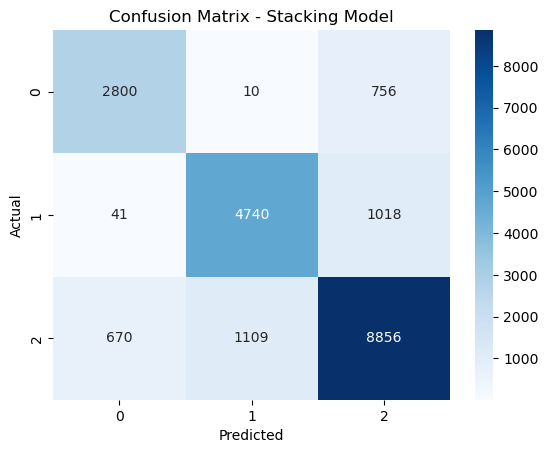

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3566
           1       0.81      0.82      0.81      5799
           2       0.83      0.83      0.83     10635

    accuracy                           0.82     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.82      0.82      0.82     20000



,Score
Accuracy,0.819800
Precision (macro),0.813206
Recall (macro),0.811766
F1 Score (macro),0.812463


In [85]:
y_pred_stacking_optuna = best_model.predict(X_test)

acc_stacking = accuracy_score(y_test, y_pred_stacking_optuna)
print(f'Accuracy Stacking Model: {acc_stacking:.4f}')

conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking_optuna)
sns.heatmap(conf_matrix_stacking, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Stacking Model')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_stacking_optuna))

# Métricas globales
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_stacking_optuna),
    'Precision (macro)': precision_score(y_test, y_pred_stacking_optuna, average='macro'),
    'Recall (macro)': recall_score(y_test, y_pred_stacking_optuna, average='macro'),
    'F1 Score (macro)': f1_score(y_test, y_pred_stacking_optuna, average='macro')
}
metrics_df = pd.DataFrame(metrics, index=["Score"]).T
display(metrics_df)

## Prediction using Random Forest

In [98]:
new_client = pd.read_csv('/Users/axelmolina/Desktop/Noveno Semestre/Modelos/Primer Proyecto/Cliente_Prueba.csv')
new_client_scaled = scaler.transform(new_client)

# Predicción
credit_category = rf_clf.predict(new_client_scaled)
print(f"Predicted Credit Category: {credit_category[0]}")

Predicted Credit Category: 0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
